In [1]:
import os
import torch
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
emotion_df = pd.read_csv('emotion_data.csv')

In [3]:
class VideoDataset(Dataset):
    def __init__(self, directory, emotion_df, transform=None, indices=None):
        super().__init__()
        self.directory = directory
        self.transform = transform
        self.emotion_df = emotion_df
        self.all_videos = self._load_video_paths()  # Load all videos initially
        self.videos = [self.all_videos[i] for i in indices] if indices is not None else self.all_videos

    def _load_video_paths(self):
        videos = []
        for root, dirs, files in os.walk(self.directory):
            video_files = [f for f in files if re.match(r'clip_\d+_frame_\d+\.png', f)]
            if video_files:
                try:
                    video_files = sorted(video_files, key=lambda x: (int(re.search(r'clip_(\d+)_frame_(\d+)\.png', x).group(1)),
                                                                     int(re.search(r'clip_(\d+)_frame_(\d+)\.png', x).group(2))))
                    video_id = os.path.basename(root)
                    emotion = self.emotion_df[self.emotion_df['Filename'].str.contains(video_id)]['Emotion'].values[0]
                    if len(video_files) > 6:
                        # Select 6 evenly spaced frames
                        indices = np.linspace(0, len(video_files) - 1, 6, dtype=int)
                        video_files = [video_files[i] for i in indices]
                    elif len(video_files) < 6:
                        # If fewer than 6, repeat the list until it has 6 elements
                        video_files = (video_files * ((6 // len(video_files)) + 1))[:6]
                    videos.append({
                        'path': root,
                        'frames': video_files,
                        'emotion': emotion - 1  # Convert emotion to 0-indexed
                    })
                except Exception as e:
                    print(f"Error processing files in {root}: {e}")
                    continue
        return videos

    def __len__(self):
        return len(self.videos)


    def __getitem__(self, idx):
        video_info = self.videos[idx]
        frames = []
        for filename in video_info['frames']:
            frame_path = os.path.join(video_info['path'], filename)
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if frame is not None else None
            if frame is not None and self.transform:
                frame = self.transform(frame)  # This should produce (C, H, W)
            frames.append(frame)

        # Stack frames along a new dimension (temporal dimension) at position 0
        frames = torch.stack(frames, dim=0)  # Now shape should be (T, C, H, W)

        # Rearrange dimensions to (C, T, H, W) for 3D ConvNet
        frames = frames.permute(1, 0, 2, 3)  # Permute dimensions to put channels first
        emotion_label = torch.tensor(video_info['emotion'], dtype=torch.long)
        return frames, emotion_label

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = VideoDataset(directory='drive/MyDrive/Data/Output', emotion_df=emotion_df, transform=transform)
video_loader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True)

In [5]:
# Split dataset into train, validation, and test sets
indices = list(range(len(full_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.30, random_state=42)
val_indices, test_indices = train_test_split(test_indices, test_size=0.50, random_state=42)

In [6]:
train_dataset = VideoDataset(directory='drive/MyDrive/Data/Output', emotion_df=emotion_df, transform=transform, indices=train_indices)
val_dataset = VideoDataset(directory='drive/MyDrive/Data/Output', emotion_df=emotion_df, transform=transform, indices=val_indices)
test_dataset = VideoDataset(directory='drive/MyDrive/Data/Output', emotion_df=emotion_df, transform=transform, indices=test_indices)

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
def show_frames(video_dataset, num_videos=1):
    for i in range(num_videos):
        video_info = video_dataset[i]  # Get a single video info
        frames, _ = video_info  # Assuming frames are returned as (T, C, H, W)

        num_frames = frames.shape[0]  # Get the actual number of frames available
        figure, ax = plt.subplots(1, num_frames, figsize=(15, 5))

        for j in range(num_frames):
            # Convert from (C, H, W) to (H, W, C)
            frame = frames[j].permute(1, 2, 0)

            # Ensure it's in the correct format for display (only RGB, no alpha)
            if frame.shape[2] > 3:
                frame = frame[:, :, :3]

            ax[j].imshow(frame.numpy())  # Convert tensor to numpy array
            ax[j].axis('off')
        plt.show()

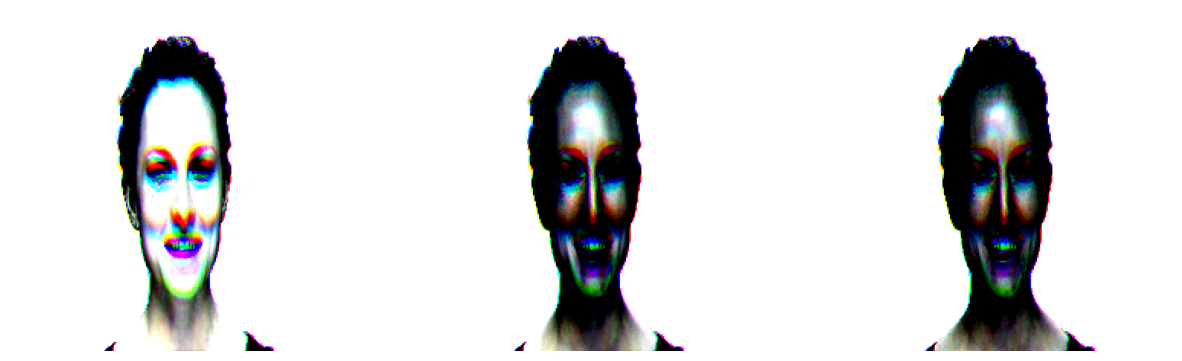

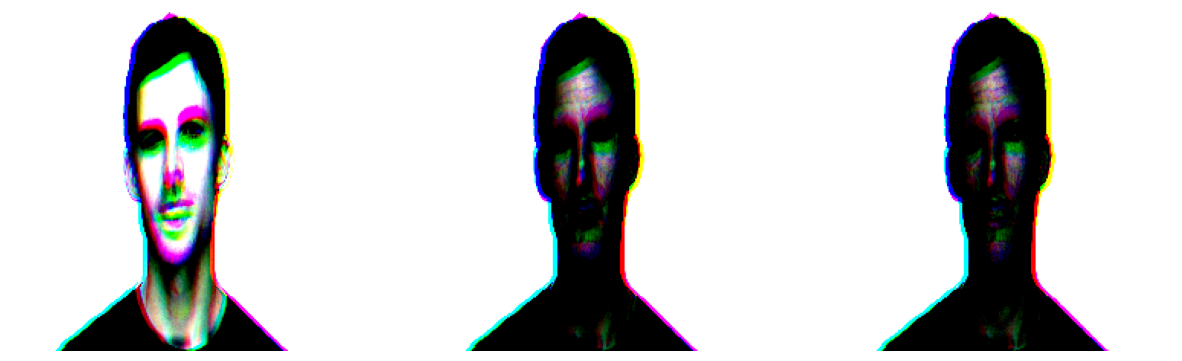

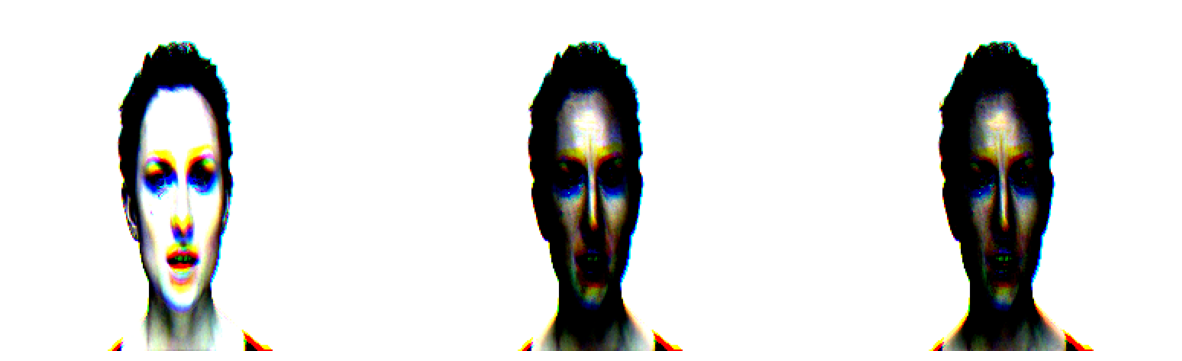

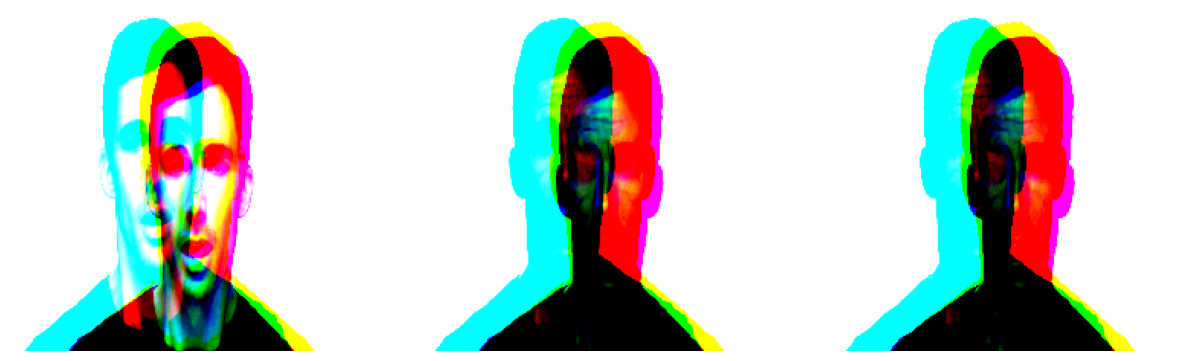

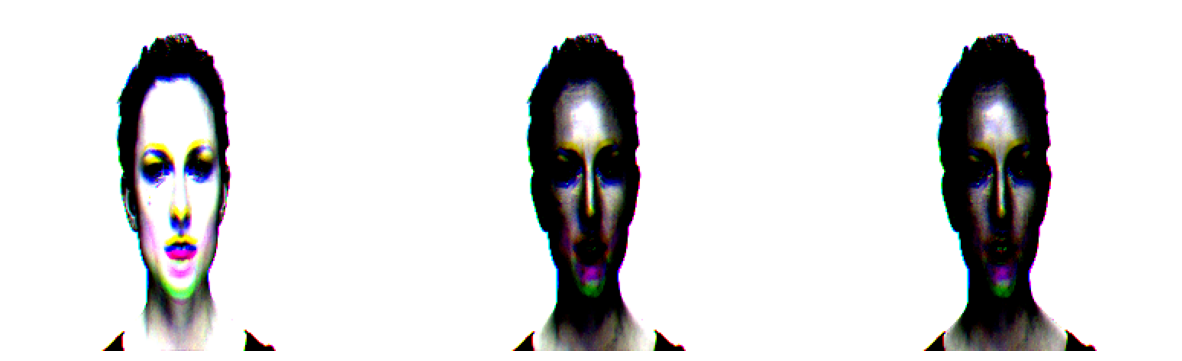

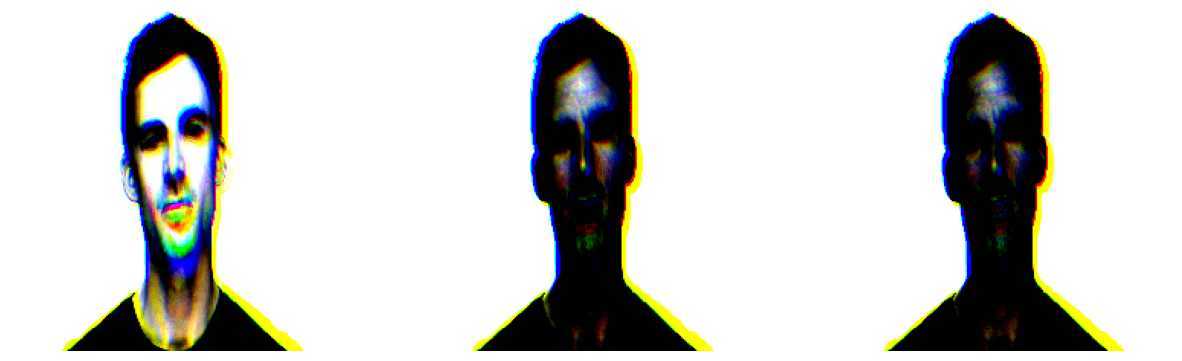

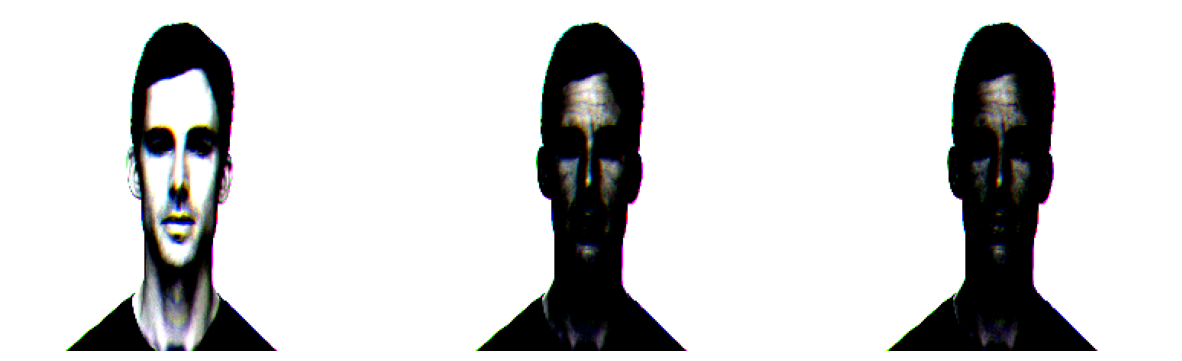

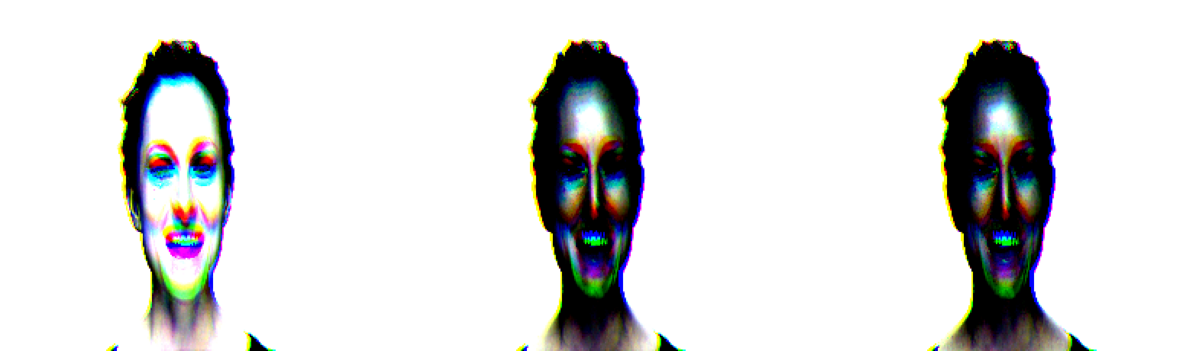

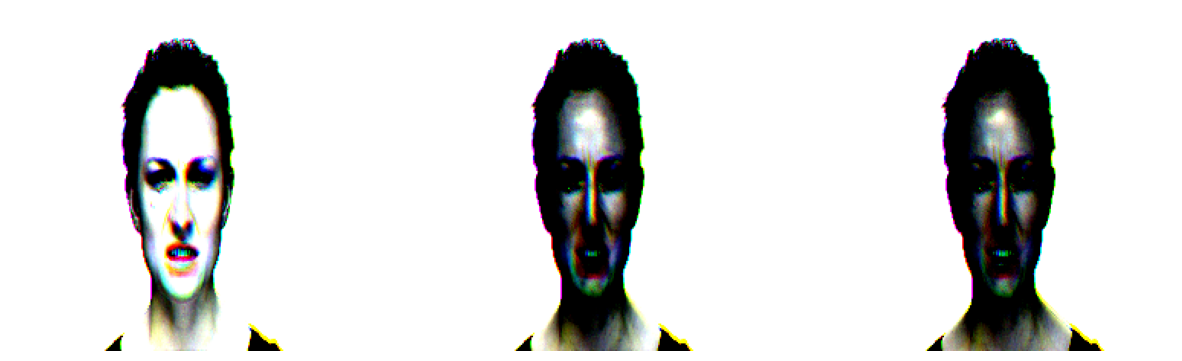

In [8]:
show_frames(train_dataset, num_videos=9)

In [9]:
class CNN3D(nn.Module):
    def __init__(self, num_classes=8):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d((2, 2, 2))
        self.dropout1 = nn.Dropout3d(0.25)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.dropout2 = nn.Dropout3d(0.25)
        self.fc1 = nn.Linear(401408, 512)  # Make sure the input size is correct after flattening
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
from torch.optim import Adam

In [11]:
def validate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(dataloader)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return val_loss, precision, recall, f1


def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)

        val_loss, precision, recall, f1 = validate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    print("Training complete.")
    return model

In [12]:
# Train model
model = CNN3D(num_classes=8)


trained_model = train_model(model, train_loader, val_loader, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Loss: 72.5039, Val Loss: 4.2952, Precision: 0.2232, Recall: 0.2735, F1: 0.1810


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Train Loss: 2.8897, Val Loss: 1.8738, Precision: 0.3146, Recall: 0.3690, F1: 0.2879


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Train Loss: 1.6607, Val Loss: 2.0938, Precision: 0.2125, Recall: 0.2375, F1: 0.1806


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Train Loss: 1.3647, Val Loss: 1.9229, Precision: 0.3580, Recall: 0.3274, F1: 0.2681


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Train Loss: 1.1957, Val Loss: 1.8241, Precision: 0.4264, Recall: 0.5137, F1: 0.3703
Epoch 6: Train Loss: 0.9363, Val Loss: 1.2875, Precision: 0.9237, Recall: 0.9048, F1: 0.8979


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Train Loss: 0.7570, Val Loss: 1.5524, Precision: 0.6278, Recall: 0.6342, F1: 0.5428
Epoch 8: Train Loss: 0.5853, Val Loss: 1.3222, Precision: 0.8653, Recall: 0.8393, F1: 0.8000
Epoch 9: Train Loss: 0.3650, Val Loss: 1.3946, Precision: 0.8839, Recall: 0.9048, F1: 0.8738
Epoch 10: Train Loss: 0.5792, Val Loss: 1.7479, Precision: 0.8464, Recall: 0.8036, F1: 0.7564
Training complete.


In [13]:
torch.save(model.state_dict(), 'emotion_classification_model_1.pth')

In [14]:
def evaluate_model(model, dataloader):
    # Check if CUDA is available and use GPU if it is, else use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Send inputs to the same device model is on
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score: {f1}')

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return f1, cm

F1 Score: 0.8340375038904451


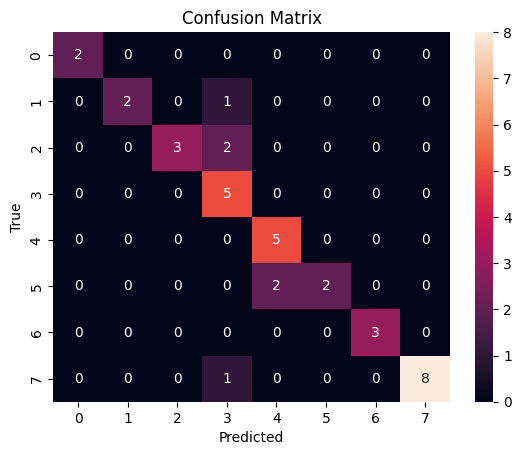

Test Accuracy: (0.8340375038904451, array([[2, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 1, 0, 0, 0, 0],
       [0, 0, 3, 2, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 2, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 1, 0, 0, 0, 8]]))


In [15]:
test_accuracy = evaluate_model(trained_model, test_loader)
print("Test Accuracy:", test_accuracy)

In [16]:
from sklearn.preprocessing import label_binarize


def plot_multiclass_roc(model, dataloader, classes):
    # Check if CUDA is available and use GPU if it is, else use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device
    model.eval()

    y_test = []
    y_score = []

    # Process batches
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = label_binarize(labels.numpy(), classes=[0, 1, 2, 3, 4, 5, 6, 7])  # Adjust classes based on your class labels
        y_test.extend(labels)

        outputs = model(inputs)
        y_score.extend(outputs.detach().cpu().numpy())

    y_test = np.array(y_test)
    y_score = np.array(y_score)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    for i in range(len(classes)):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for class {}'.format(classes[i]))
        plt.legend(loc="lower right")
        plt.show()

    return roc_auc

In [17]:
classes = [0, 1, 2, 3, 4, 5, 6, 7]

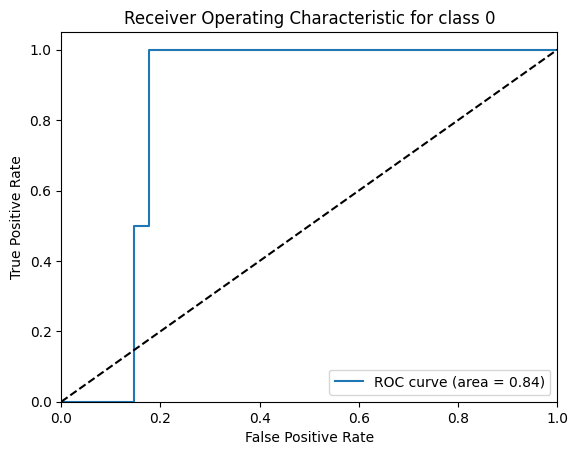

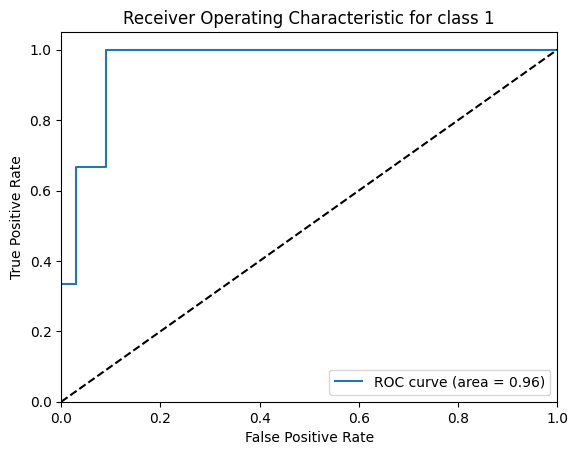

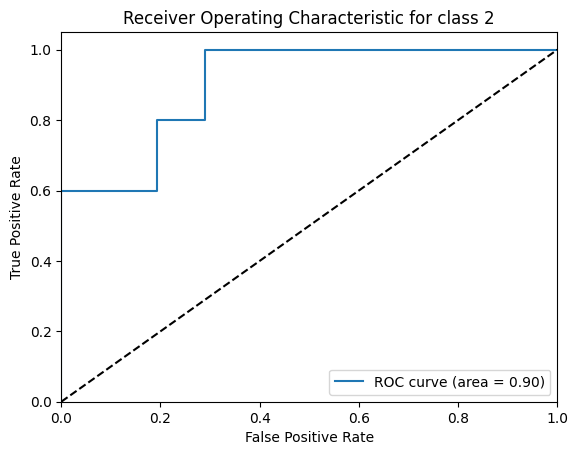

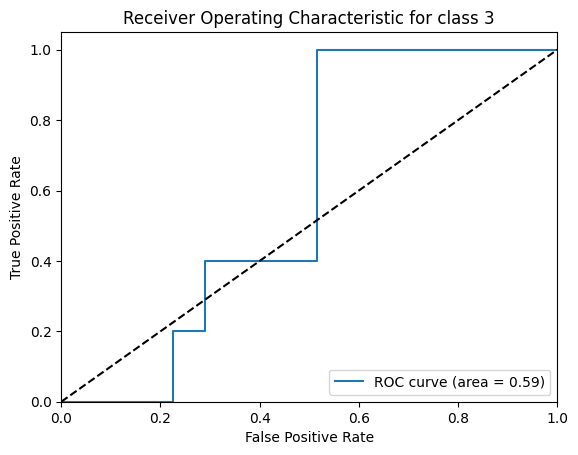

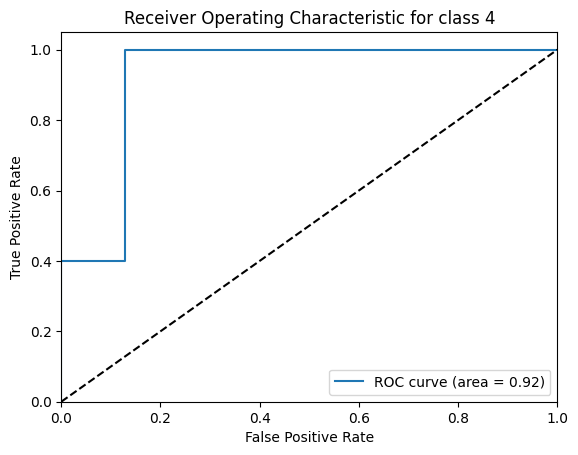

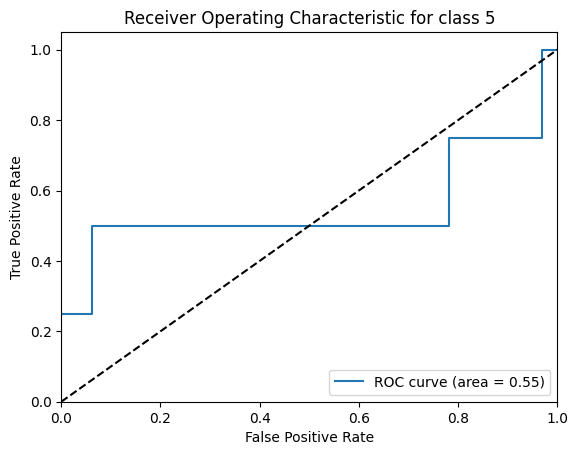

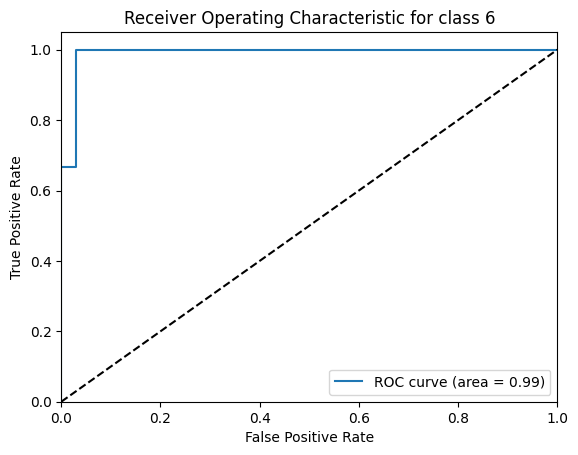

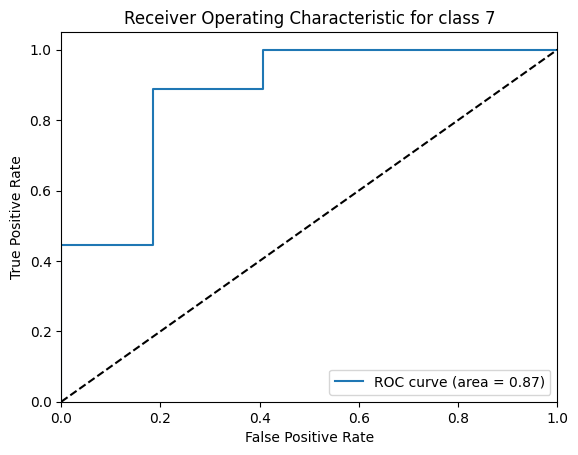

{0: 0.838235294117647, 1: 0.9595959595959596, 2: 0.903225806451613, 3: 0.5870967741935484, 4: 0.9225806451612903, 5: 0.546875, 6: 0.98989898989899, 7: 0.8724279835390946}


In [18]:
roc_auc = plot_multiclass_roc(trained_model, test_loader, classes)
print(roc_auc)

In [19]:
def get_metrics(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average=None)  # returns array for each class
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)

    return precision, recall, f1

In [20]:
def plot_classification_metrics(model, dataloader, class_names):
    precision, recall, f1 = get_metrics(model, dataloader)

    x = np.arange(len(class_names))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1, width, label='F1 Score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title('Precision, Recall and F1 Score by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()

    # Add a legend and show the plot
    ax.legend()
    plt.show()

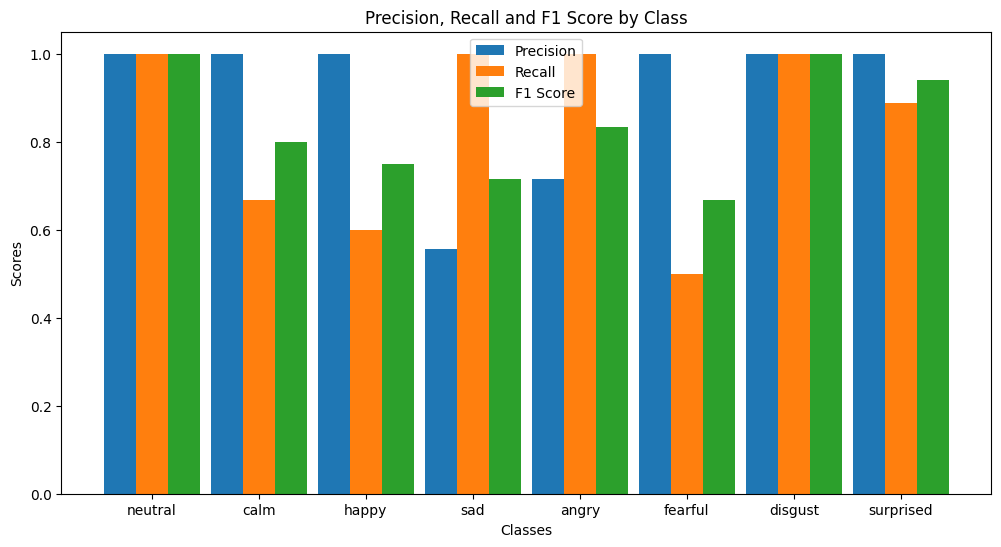

In [21]:
class_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  # Replace with your actual class names
plot_classification_metrics(model, test_loader, class_names)